# 🧾 Step 1: Setup Notebook

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🧾 Step 2: Load Data

Format needed:
``` bash
time,open,high,low,close,volume
2023-01-01 00:00,1.0672,1.0679,1.0665,1.0675,123
```

In [2]:
# Read the raw CSV (tab-separated, assuming first column is index)
df_raw = pd.read_csv("GBPUSD_M5.csv", sep='\t', header=0)  # Update filename if needed

# Combine DATE and TIME into a single time column
df_raw['time'] = pd.to_datetime(df_raw['<DATE>'] + ' ' + df_raw['<TIME>'], format='%Y.%m.%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M')

# Drop the unnecessary columns
df_raw = df_raw.drop(columns=['<VOL>', '<SPREAD>', '<DATE>', '<TIME>'])

# Move the last column ('time') to the first position
df_raw = df_raw[['time'] + [col for col in df_raw.columns if col != 'time']]

# Select and rename columns to match desired format
df_raw = df_raw[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']]
df_raw.columns = ['open', 'high', 'low', 'close', 'volume']

df = df_raw.copy()
df.head()

,open,high,low,close,volume
0,1.25543,1.25547,1.25531,1.25541,25
1,1.25544,1.25573,1.25539,1.25556,26
2,1.25556,1.25556,1.25545,1.25552,21
3,1.25551,1.25558,1.25545,1.25552,25
4,1.25552,1.25567,1.25547,1.25567,36


# 🧾 Step 3: Feature Engineering

We’ll use some simple features first:

- Returns (1, 3, 6 bars back)

- Rolling volatility

- Moving average difference

In [3]:
# Returns
df["ret_1"] = df["close"].pct_change(1)
df["ret_3"] = df["close"].pct_change(3)
df["ret_6"] = df["close"].pct_change(6)

# Rolling volatility
df["vol_roll"] = df["ret_1"].rolling(20).std()

# Moving average difference
df["ma_fast"] = df["close"].rolling(10).mean()
df["ma_slow"] = df["close"].rolling(50).mean()
df["ma_diff"] = (df["ma_fast"] - df["ma_slow"]) / df["close"]

# Drop missing values
df.dropna(inplace=True)

df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,vol_roll,ma_fast,ma_slow,ma_diff
49,1.25556,1.25559,1.25540,1.25547,111,-0.000072,-0.000271,-0.000143,0.000099,1.255601,1.255716,-0.000091
50,1.25548,1.25557,1.25546,1.25547,104,0.000000,-0.000191,-0.000183,0.000086,1.255606,1.255717,-0.000088
51,1.25548,1.25558,1.25532,1.25536,190,-0.000088,-0.000159,-0.000358,0.000087,1.255603,1.255713,-0.000087
52,1.25536,1.25552,1.25528,1.25528,144,-0.000064,-0.000151,-0.000422,0.000086,1.255582,1.255708,-0.000100
53,1.25528,1.25538,1.25528,1.25534,69,0.000048,-0.000104,-0.000295,0.000077,1.255551,1.255704,-0.000122


# 🧾 Step 4: Create Target (Up/Down)

We’ll predict next bar direction:

- 1 if next close is higher (BUY)

- 0 if next close is lower (SELL)

In [4]:
df["target"] = (df["close"].shift(-1) > df["close"]).astype(int)

df.head()

,open,high,low,close,volume,ret_1,ret_3,ret_6,vol_roll,ma_fast,ma_slow,ma_diff,target
49,1.25556,1.25559,1.25540,1.25547,111,-0.000072,-0.000271,-0.000143,0.000099,1.255601,1.255716,-0.000091,0
50,1.25548,1.25557,1.25546,1.25547,104,0.000000,-0.000191,-0.000183,0.000086,1.255606,1.255717,-0.000088,0
51,1.25548,1.25558,1.25532,1.25536,190,-0.000088,-0.000159,-0.000358,0.000087,1.255603,1.255713,-0.000087,0
52,1.25536,1.25552,1.25528,1.25528,144,-0.000064,-0.000151,-0.000422,0.000086,1.255582,1.255708,-0.000100,1
53,1.25528,1.25538,1.25528,1.25534,69,0.000048,-0.000104,-0.000295,0.000077,1.255551,1.255704,-0.000122,1


# 🧾 Step 5: Split Data

In [5]:
features = ["ret_1", "ret_3", "ret_6", "vol_roll", "ma_diff"]
X = df[features]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 🧾 Step 6: Train XGBoost Model

In [6]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
print("Model training completed.")

Model training completed.


# 🧾 Step 7: Evaluate Model

Accuracy: 0.511
AUC: 0.509


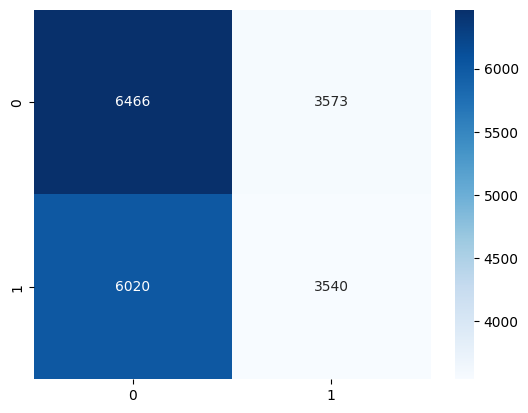

In [7]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f}")
print(f"AUC: {auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# 🧾 Step 8: Save Model

In [8]:
import joblib
joblib.dump(model, "forex_model.pkl")

['forex_model.pkl']

# 🧾 Step 9: Backtest inside Jupyter

In [9]:
# Use the trained model
y_proba = model.predict_proba(X_test)[:, 1]   # probability of "up"
y_pred = (y_proba > 0.5).astype(int)          # binary prediction

# Copy test set
bt = df.iloc[-len(X_test):].copy()
bt["prediction"] = y_pred
bt["probability"] = y_proba

# Simulated strategy: if model says up -> take close, else short
bt["strategy_return"] = bt["prediction"].shift(1) * bt["ret_1"]

# Cumulative equity curves
bt["market_cum"] = (1 + bt["ret_1"]).cumprod()
bt["strategy_cum"] = (1 + bt["strategy_return"]).cumprod()

# 🧾 Step 10: Plot Equity Curves vs Price

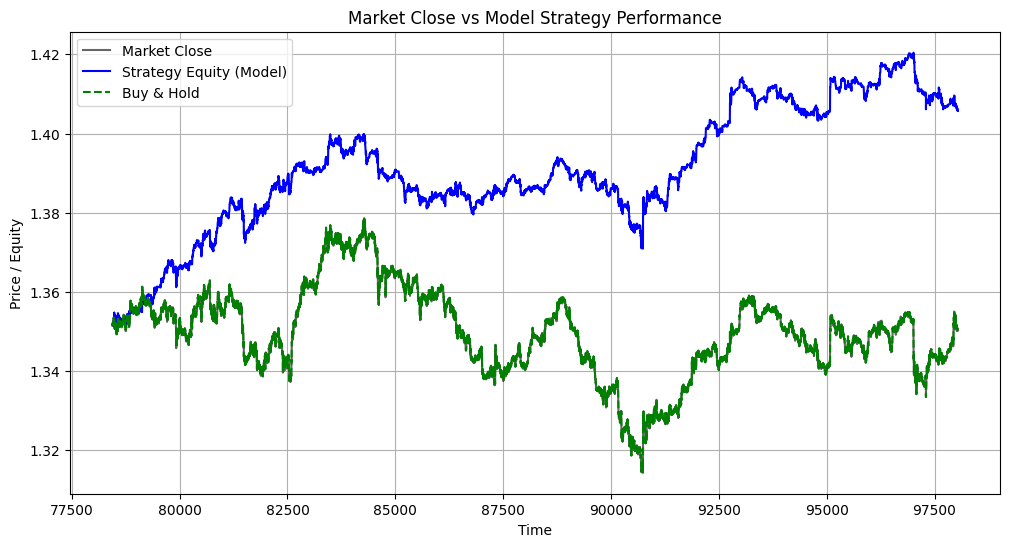

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Market price (closing)
plt.plot(bt.index, bt["close"], label="Market Close", color="black", alpha=0.6)

# Strategy equity curve
plt.plot(bt.index, bt["strategy_cum"] * bt["close"].iloc[0], 
         label="Strategy Equity (Model)", color="blue")

# Market buy & hold equity
plt.plot(bt.index, bt["market_cum"] * bt["close"].iloc[0], 
         label="Buy & Hold", color="green", linestyle="--")

plt.legend()
plt.title("Market Close vs Model Strategy Performance")
plt.xlabel("Time")
plt.ylabel("Price / Equity")
plt.grid(True)
plt.show()


# 🧾 Step 11: Plot Signals on Chart

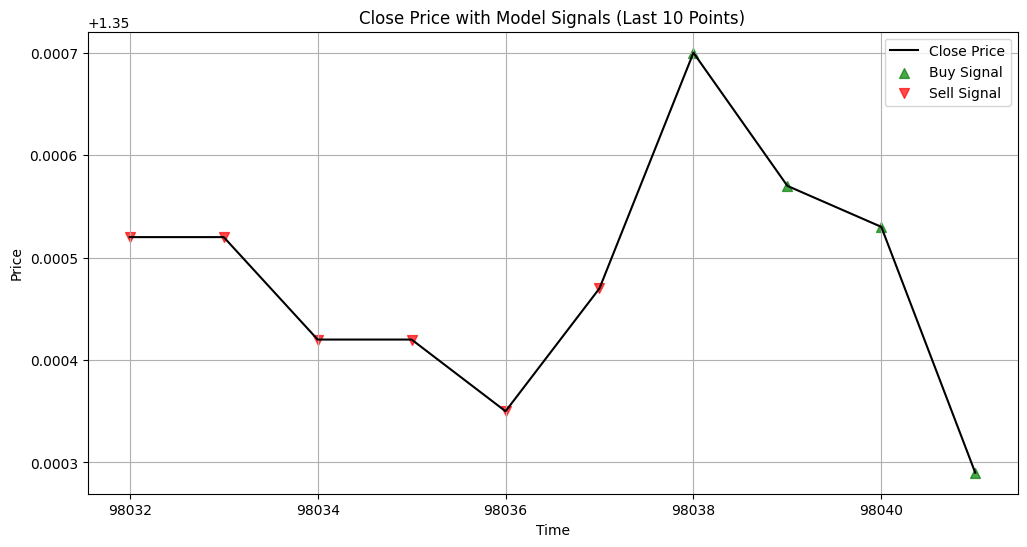

In [11]:
# Focus on the last 200 points for clarity
bt_focus = bt.tail(10)

plt.figure(figsize=(12,6))
plt.plot(bt_focus.index, bt_focus["close"], label="Close Price", color="black")

# Plot buy signals
plt.scatter(bt_focus.index[bt_focus["prediction"]==1], 
            bt_focus["close"][bt_focus["prediction"]==1],
            marker="^", color="green", alpha=0.7, label="Buy Signal", s=50)

# Plot sell signals
plt.scatter(bt_focus.index[bt_focus["prediction"]==0], 
            bt_focus["close"][bt_focus["prediction"]==0],
            marker="v", color="red", alpha=0.7, label="Sell Signal", s=50)

plt.legend()
plt.title(f"Close Price with Model Signals (Last {bt_focus.shape[0]} Points)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()